# Fig. 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib
import xarray as xr 

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")


## Funtions 

In [2]:
def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy

## Get Data

In [3]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]
z = z.assign_coords(height=dsref.height)

In [4]:
# First Set
ds01 = xr.open_mfdataset(data_path + "exp_001.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds02 = xr.open_mfdataset(data_path + "exp_002.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds03 = xr.open_mfdataset(data_path + "exp_003.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds04 = xr.open_mfdataset(data_path + "exp_004.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds08 = xr.open_mfdataset(data_path + "exp_008.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()

# Second Set 
ds09 = xr.open_mfdataset(data_path + "exp_009.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds13 = xr.open_mfdataset(data_path + "exp_013.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds17 = xr.open_mfdataset(data_path + "exp_017.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds21 = xr.open_mfdataset(data_path + "exp_021.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()
ds28 = xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze()

## Prepare Plot

In [5]:
flux_set1 = [25, 35, 45,50]
ds_list1 = [ ds02, ds03, ds04, ds08]

flux_set2 = [60, 75, 100, 150, 200]
ds_list2 = [ds09, ds13, ds17, ds21, ds28]


In [6]:
q1 = 0.05
quants1 = []
quants2 = []

    
for j, ds in enumerate(ds_list1):
        quants1 = np.append(quants1, quantile_height(ds.mean("time"), quantile=q1))


for j, ds in enumerate(ds_list2):
        quants2 = np.append(quants2, quantile_height(ds.mean("time"), quantile=q1))

## Plot figure

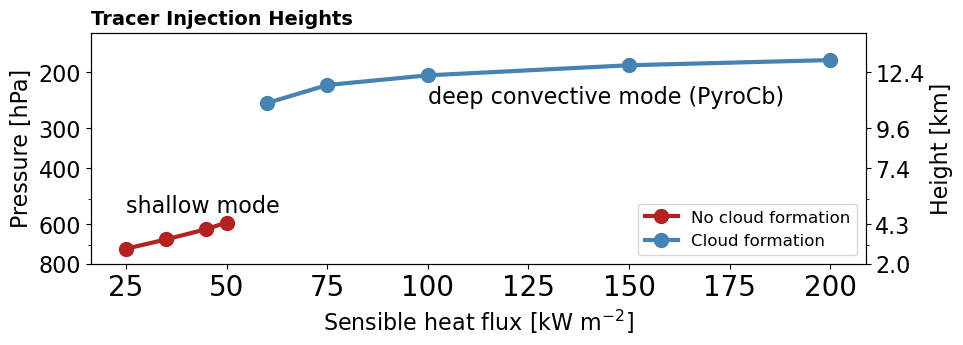

In [7]:

# Define y-ticks for the pressure axis
y_ticks = [200, 300, 400, 600, 800]

# Create the plot with a specified figure size
fig, ax = plt.subplots(1, 1, figsize=[10, 3])

# Plot the data for flux set 1 and flux set 2 with distinct colors and markers
ax.plot(flux_set1, quants1, color="firebrick", linewidth=3, marker="o", markersize=10, label="No cloud formation")
ax.plot(flux_set2, quants2, color="steelblue", linewidth=3, marker="o", markersize=10, label="Cloud formation")

# Set axis properties for the primary axis
ax.invert_yaxis()
ax.set_yscale("log")
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=16)
ax.set_xlabel(r"Sensible heat flux [kW m$^{-2}$]", fontsize=16)
ax.set_ylabel("Pressure [hPa]", fontsize=16)
ax.set_title("Tracer Injection Heights", fontweight="bold", loc="left", fontsize=14)
ax.legend(loc='lower right', fontsize=12)
ax.set_ylim(800, 150)

# Add text annotations to indicate different modes
ax.text(25, 550, "shallow mode", fontsize=16)
ax.text(100, 250, "deep convective mode (PyroCb)", fontsize=16)

# Create a secondary y-axis for height
ax2 = ax.twinx()
ax2.set_yscale("log")
ax2.set_yticks(y_ticks)

# Set the y-tick labels for the secondary axis to show heights in km
height_labels = np.round(0.001 * z.sel(height=y_ticks, method="nearest").values, 1)
ax2.set_yticklabels(height_labels, fontsize=16)
ax2.set_ylim(800, 150)
ax2.set_ylabel("Height [km]", fontsize=16)

# Save the figure in high and low quality
my_path = "./figs/"
fig.savefig(my_path + 'fig04.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig04_lq.png', dpi=50, bbox_inches='tight')

# Display the plot
plt.show()
